In [1]:
import GEOparse
import pandas as pd
import numpy as np

GEOparse.logger.set_verbosity("ERROR")

In [ ]:
gse = GEOparse.get_GEO(geo='GSE116222', destdir="./data/geo_cache")

platform_id = gse.metadata['platform_id'][0]
print(f"Platform ID: {platform_id}")

expr_matrix = gse.pivot_samples('VALUE')
expr_matrix_t = expr_matrix.T
values_df = pd.DataFrame(expr_matrix_t)
locations = gse.gpls[next(iter(gse.gpls))].table.set_index('ID')

In [7]:
# read gz file
import gzip

with gzip.open('./data/geo_cache/GSE116222_Expression_matrix.txt.gz', 'rt') as f:
    expr_matrix = pd.read_csv(f, sep='\t', index_col=0)

In [21]:
expression_data = expr_matrix.T

labels = expression_data.index.str.split('-').str[1].to_list()

In [47]:
inflammation_labels = ['UC inflamed' if x.endswith('3') else 'UC non-inflamed' if x.endswith('2') else 'Healthy' for x in labels]

In [ ]:
# visualize the data using UMAP
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP()
embedding = reducer.fit_transform(expression_data)

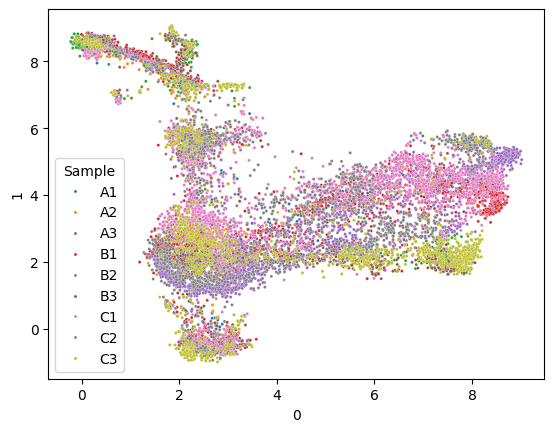

In [54]:
import seaborn as sns

plot_data = pd.concat([pd.DataFrame(embedding), pd.Series(labels).rename('Sample')], axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="Sample", s=5);

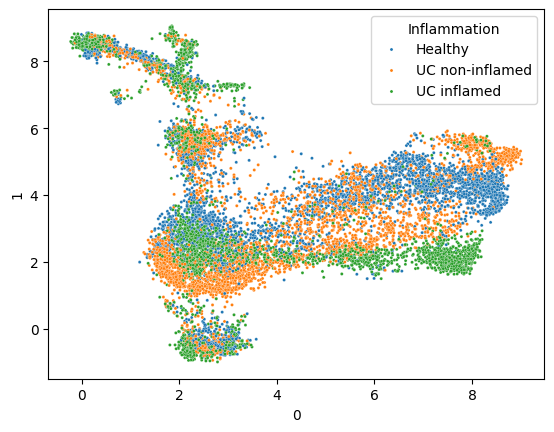

In [53]:
import seaborn as sns

plot_data = pd.concat([pd.DataFrame(embedding), pd.Series(inflammation_labels).rename('Inflammation')], axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="Inflammation", s=5);

In [13]:
gse.phenotype_data.iloc[100, :].head(60)

title                                                           5253 UC Uninflamed sigmoid colon
geo_accession                                                                          GSM282955
status                                                                     Public on Jun 17 2008
submission_date                                                                      Apr 21 2008
last_update_date                                                                     Apr 12 2017
type                                                                                         RNA
channel_count                                                                                  2
source_name_ch1                                                      UC Uninflamed sigmoid colon
organism_ch1                                                                        Homo sapiens
taxid_ch1                                                                                   9606
characteristics_ch1.0.patient 

In [17]:
gse.phenotype_data['source_name_ch1'].value_counts(dropna=False)

source_name_ch1
UC Inflamed sigmoid colon             32
UC Uninflamed sigmoid colon           25
Normal Uninflamed sigmoid colon       24
Normal Uninflamed descending colon    22
UC Uninflamed ascending colon         21
UC Inflamed descending colon          19
Normal Uninflamed ascending colon     17
UC Uninflamed descending colon        15
UC Inflamed ascending colon           11
Normal Uninflamed terminal ileum       6
UC Uninflamed terminal ileum           5
Normal Inflamed sigmoid colon          3
Normal Inflamed descending colon       1
UC Inflamed terminal ileum             1
Name: count, dtype: int64

In [22]:
gse.phenotype_data['source_name_ch1'].map(lambda x: x.split(' ')[-1]).value_counts(dropna=False)

source_name_ch1
colon    190
ileum     12
Name: count, dtype: int64

In [16]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()


class GPTMetadataProcessor():
    def __init__(self):
        self.client = OpenAI()
        
        with open('../core/data_processing/system_prompt.txt', 'r') as f:
            self.system_prompt = f.read()
        

    def process(self, dataset):
        completion = self.client.chat.completions.create(
          model="gpt-4-turbo-preview",
          messages=[
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": dataset.to_csv()}
          ],
          temperature=0,
          n=1
        )

        return completion.choices[0].message.content

In [17]:
processor = GPTMetadataProcessor()

In [18]:
processed_metadata = processor.process(gse.phenotype_data.iloc[:10])

In [21]:
from io import StringIO

asdf = pd.read_csv(StringIO(processed_metadata))

asdf.set_index('sample_id')

,patient_id,disease,treatment,response,time_of_biopsy,tissue,inflammation
sample_id,,,,,,,
GSM364627,NaN,Healthy,NaN,NaN,W0,Colon,NaN
GSM364628,NaN,Healthy,NaN,NaN,W0,Colon,NaN
GSM364629,NaN,Healthy,NaN,NaN,W0,Colon,NaN
GSM364630,NaN,Healthy,NaN,NaN,W0,Colon,NaN
GSM364631,NaN,Healthy,NaN,NaN,W0,Colon,NaN
GSM364632,NaN,Healthy,NaN,NaN,W0,Colon,NaN
GSM364633,UCR1,UC,Infliximab,Yes,W0,Colon,NaN
GSM364634,UCR2,UC,Infliximab,Yes,W0,Colon,NaN
GSM364635,UCR3,UC,Infliximab,Yes,W0,Colon,NaN


In [13]:
gse.phenotype_data['characteristics_ch1.0.Tissue'].unique()


array(['Nonneoplastic rectal mucosa', 'Colorecal Cancer'], dtype=object)

In [2]:
y_inflammation = pd.Series(['Inflamed' in  l for l in gse.phenotype_data.source_name_ch1], index=gse.phenotype_data.index)
y_uc = pd.Series(['UC' in l for l in gse.phenotype_data.source_name_ch1], index=gse.phenotype_data.index)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

X = expr_df.dropna(axis=1) 
y = y_inflammation.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.8780487804878049
AUC: 0.8695054945054945


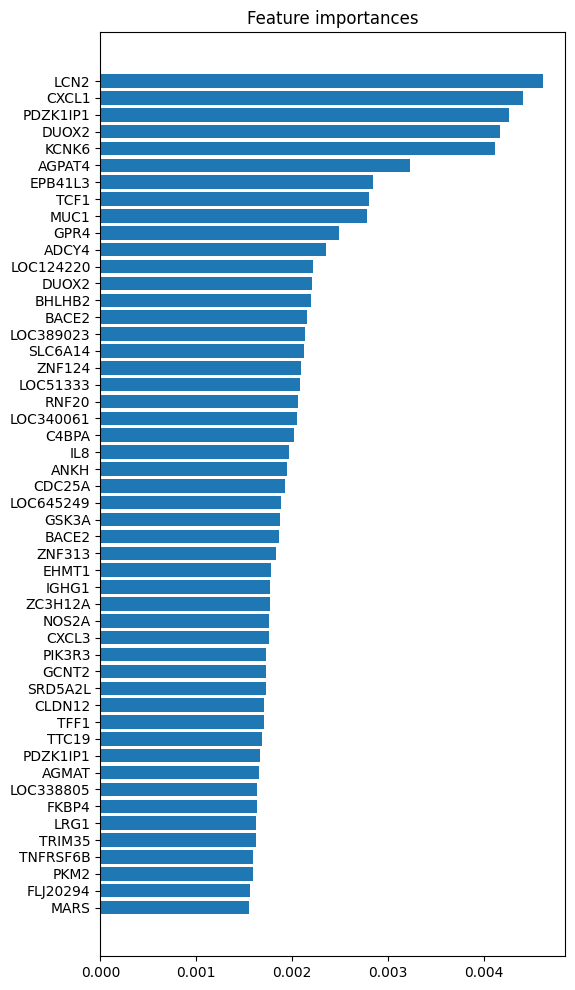

In [4]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:50]

plt.figure(figsize=(6, 12))
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), X.columns[indices])
# sort the y axis labels so they are in descending order of feature importance
plt.gca().invert_yaxis()
plt.show()
